In [1]:
import pandas as pd
all_sharpe_ratio = pd.read_csv("results_sharpe/all_sharpe_ratio.csv")
all_sharpe_ratio = all_sharpe_ratio.drop(columns=["Unnamed: 0"], errors="ignore")
all_3f_alpha = pd.read_csv("results_alpha/all_3f_alpha.csv")
all_4f_alpha = pd.read_csv("results_alpha/all_4f_alpha.csv")
all_5f_alpha = pd.read_csv("results_alpha/all_5f_alpha.csv")

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import t
from typing import List, Sequence, Callable, Tuple
from itertools import islice

class InvalidParameterException(Exception):
    """Exception raised for invalid input parameters."""
    def __init__(self, message: str):
        super().__init__(message)

class ZeroVarianceException(ArithmeticError):
    """Exception raised when variance in DM test is zero."""
    def __init__(self, message: str):
        super().__init__(message)

def autocovariance(X: Sequence[float], k: int, mean: float) -> float:
    """Returns the k-lagged autocovariance for the input iterable."""
    return sum((a - mean) * (b - mean) for a, b in zip(islice(X, k, None), X)) / len(X)

def evaluate_pvalue(pvalue: float) -> int:
    """
    Evaluates the p-value to determine model equivalence.
    - Returns 1 if p-value >= 0.05 (statistically similar, fail to reject H0)
    - Returns -1 if p-value < 0.05 (statistically different, reject H0)
    """
    return 1 if pvalue >= 0.05 else -1

def dm_test(
    V: Sequence[float],
    P1: Sequence[float],
    P2: Sequence[float],
    *,
    loss: Callable[[float, float], float] = lambda u, v: (u - v) ** 2,
    h: int = 1,
    one_sided: bool = False,
    harvey_correction: bool = True
) -> Tuple[float, float]:
    """
    Performs the Diebold-Mariano (DM) test for predictive accuracy comparison.

    Parameters:
    - V: True observed values
    - P1: Forecasts from model 1
    - P2: Forecasts from model 2
    - loss: Loss function (default is squared error loss)
    - h: Forecast horizon (default: 1)
    - one_sided: Whether to use a one-sided test (default: False)
    - harvey_correction: Whether to apply Harvey adjustment (default: True)

    Returns:
    - DM test statistic
    - p-value
    """
    d = np.array([loss(V[i], P1[i]) - loss(V[i], P2[i]) for i in range(len(V))])
    mean_d = np.mean(d)

    # Compute HAC variance estimate
    gamma = np.array([np.cov(d[:-i], d[i:])[0, 1] if i > 0 else np.var(d, ddof=1) for i in range(h)])
    var_d = (gamma[0] + 2 * np.sum(gamma[1:])) / len(d)

    if var_d == 0:
        raise ZeroVarianceException("Variance of the DM statistic is zero. The prediction series might be identical.")

    dm_stat = mean_d / np.sqrt(var_d)

    # Apply Harvey correction if required
    n = len(d)
    if harvey_correction:
        harvey_adj = np.sqrt((n + 1 - 2 * h + h * (h - 1) / n) / n)
        dm_stat *= harvey_adj

    # Compute p-value
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=n-1)) if not one_sided else (1 - t.cdf(dm_stat, df=n-1))

    return dm_stat, p_value

def generate_dm_test_matrix(results_df: pd.DataFrame, outcome_var: str, forecast_vars: List[str]
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generates a pairwise DM test statistic and p-value matrix from a results DataFrame.

    Parameters:
    - results_df: DataFrame containing the true values and forecasts
    - outcome_var: Column name of the observed outcome variable
    - forecast_vars: List of column names corresponding to forecasts

    Returns:
    - DataFrame of DM test statistics
    - DataFrame of p-values
    """
    n = len(forecast_vars)
    dm_stat_matrix = np.zeros((n, n))
    pvalue_matrix = np.zeros((n, n))

    for i, f1 in enumerate(forecast_vars):
        for j, f2 in enumerate(forecast_vars):
            if i == j:
                dm_stat_matrix[i, j] = 0
                pvalue_matrix[i, j] = 0
            elif i < j:  # Compute only for upper triangle and mirror values
                try:
                    common_index = results_df[outcome_var].dropna().index
                    V = results_df.loc[common_index, outcome_var].values
                    P1 = results_df.loc[common_index, f1].values
                    P2 = results_df.loc[common_index, f2].values

                    dmstat, pvalue = dm_test(V, P1, P2, one_sided=True)

                    dm_stat_matrix[i, j] = dmstat
                    pvalue_matrix[i, j] = evaluate_pvalue(pvalue)
                    dm_stat_matrix[j, i] = -dmstat  # Maintain symmetry
                    pvalue_matrix[j, i] = evaluate_pvalue(pvalue)  # Ensure p-value symmetry

                except Exception as e:
                    dm_stat_matrix[i, j] = np.nan
                    pvalue_matrix[i, j] = np.nan
                    dm_stat_matrix[j, i] = np.nan
                    pvalue_matrix[j, i] = np.nan

    # Convert matrices to DataFrame format
    dm_stat_df = pd.DataFrame(dm_stat_matrix, index=forecast_vars, columns=forecast_vars)
    pvalue_df = pd.DataFrame(pvalue_matrix, index=forecast_vars, columns=forecast_vars)

    return dm_stat_df, pvalue_df

Transformations to make DM Matrix

In [3]:
def transform_matrix(df):
    transformed_df = df.copy().astype(str)
    for row in df.index:
        for col in df.columns:
            if df.loc[row, col] < 0:
                transformed_df.loc[row, col] = "row"  # Row model is better
            elif df.loc[row, col] > 0:
                transformed_df.loc[row, col] = "col"  # Column model is better
            else:
                transformed_df.loc[row, col] = "same"  # Same model
    return transformed_df

def apply_equivalent(dm_transformed, reference_df):
    dm_transformed_updated = dm_transformed.copy()
    for row in dm_transformed.index:
        for col in dm_transformed.columns:
            if reference_df.loc[row, col] == -1:
                continue
            elif reference_df.loc[row, col] > 0:
                dm_transformed_updated.loc[row, col] = "equivalent"  # Column model is better
            else:
                continue  # Same model
    return dm_transformed_updated

def overall_transformation(dm_stat_df, dm_pvalue_df):
    dm_transformed = transform_matrix(dm_stat_df)
    dm_transformed_updated = apply_equivalent(dm_transformed, dm_pvalue_df)
    return dm_transformed_updated

Plotting Function

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

def heat_map_plotter(df):
    mapping = {"row": -1, "same": 0, "equivalent": 1, "col": 2}  # Ensure "equivalent" and "same" are treated the same

    # Convert categorical values to numerical for visualization
    dm_numeric = df.replace(mapping)

    # Define renaming mapping
    rename_mapping = {
        "linear_3f": "Linear",
        "linear_4f": "Linear",
        "linear_5f": "Linear",
        "ffnn_3f": "NN1",
        "ffnn_4f": "NN1",
        "ffnn_5f": "NN1",
        "rf_3f": "RF",
        "rf_4f": "RF",
        "rf_5f": "RF",
        "3f_rnn": "RNN",
        "4f_rnn": "RNN",
        "5f_rnn": "RNN",
    }

    # Rename index and columns (if needed)
    dm_numeric_renamed = dm_numeric.rename(index=rename_mapping, columns=rename_mapping)

    # Define color mapping
    cmap = ListedColormap(["lightseagreen", "#000000", "crimson", "navy"])  
    # Red = "row", Black = "same/equivalent", White = unused, Blue = "col"

    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]  # Ensure distinct bins for each category
    norm = BoundaryNorm(bounds, cmap.N)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(dm_numeric_renamed, dtype=bool),k=1)

    # Set the upper triangle to NaN
    dm_numeric_masked = dm_numeric_renamed.mask(mask)

    # Create a figure
    plt.figure(figsize=(10, 8))

    # Draw heatmap without borders
    ax = sns.heatmap(
        dm_numeric_masked,
        cmap=cmap,
        norm=norm,
        mask=mask,
        cbar=False,
        linewidths=0,  # Remove default grid lines
        linecolor="black"  # Will be used selectively
    )

    # Manually add black outlines only to colored squares
    for i in range(dm_numeric_masked.shape[0]):
        for j in range(dm_numeric_masked.shape[1]):
            value = dm_numeric_masked.iloc[i, j]
            if value in [-1, 1]:  # -1 (row model better), 2 (col model better)
                rect = plt.Rectangle(
                    (j, i), 1, 1, fill=False, edgecolor="black", linewidth=1
                )
                ax.add_patch(rect)

    # Add a legend manually
    legend_patches = [
        mpatches.Patch(color="lightseagreen", label="Model 1 Better"),
        mpatches.Patch(color="crimson", label="Forecast Equivalence"),
        mpatches.Patch(color="navy", label="Model 2 Better"),
        mpatches.Patch(color="#000000", label="NA")
    ]

    plt.xlabel("Model 2", fontsize=14, fontweight = "bold")
    plt.ylabel("Model 1", fontsize=14, fontweight = "bold")

    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(handles=legend_patches, loc="upper right", title="Categories", frameon=True,
            title_fontsize = 14, fontsize = 12, bbox_to_anchor=(0.9, 0.9))
    plt.show()

# heat_map_plotter(dm_transformed_updated_3f)
# heat_map_plotter(dm_transformed_updated_4f)
# heat_map_plotter(dm_transformed_updated_5f)

In [6]:
# DM Test for all outcomes
outcome_var = 'rolling_sharpe'
forecast_vars_3f = ['linear_3f', 'ffnn_3f', 'rf_3f', '3f_rnn']
forecast_vars_4f = ['linear_4f', 'ffnn_4f', 'rf_4f', '4f_rnn']
forecast_vars_5f = ['linear_5f', 'ffnn_5f', 'rf_5f', '5f_rnn']

dm_stat_df_3f_sharpe, dm_pvalue_df_3f_sharpe = generate_dm_test_matrix(all_sharpe_ratio, outcome_var, forecast_vars_3f)
dm_stat_df_4f_sharpe, dm_pvalue_df_4f_sharpe = generate_dm_test_matrix(all_sharpe_ratio, outcome_var, forecast_vars_4f)
dm_stat_df_5f_sharpe, dm_pvalue_df_5f_sharpe = generate_dm_test_matrix(all_sharpe_ratio, outcome_var, forecast_vars_5f)

dm_transformed_updated_3f_sharpe = overall_transformation(dm_stat_df_3f_sharpe,dm_pvalue_df_3f_sharpe)
dm_transformed_updated_4f_sharpe = overall_transformation(dm_stat_df_4f_sharpe,dm_pvalue_df_4f_sharpe)
dm_transformed_updated_5f_sharpe = overall_transformation(dm_stat_df_5f_sharpe,dm_pvalue_df_5f_sharpe)

outcome_var_4f_alpha = 'rolling_alpha_4f'
forecast_vars_4f_alpha = ['linear_4f', 'ffnn_4f', 'rf_4f', 'rnn_4f']

outcome_var_5f_alpha = 'rolling_alpha_5f'
forecast_vars_5f_alpha = ['linear_5f', 'ffnn_5f', 'rf_5f', 'rnn_5f']

outcome_var_3f_alpha = 'rolling_alpha_3f'
forecast_vars_3f_alpha = ['linear_3f', 'ffnn_3f', 'rf_3f', 'rnn_3f']

dm_stat_df_3f_alpha, dm_pvalue_df_3f_alpha = generate_dm_test_matrix(all_3f_alpha, outcome_var_3f_alpha, forecast_vars_3f_alpha)
dm_stat_df_4f_alpha, dm_pvalue_df_4f_alpha = generate_dm_test_matrix(all_4f_alpha, outcome_var_4f_alpha, forecast_vars_4f_alpha)
dm_stat_df_5f_alpha, dm_pvalue_df_5f_alpha = generate_dm_test_matrix(all_5f_alpha, outcome_var_5f_alpha, forecast_vars_5f_alpha)

dm_transformed_updated_3f_alpha = overall_transformation(dm_stat_df_3f_alpha,dm_pvalue_df_3f_alpha)
dm_transformed_updated_4f_alpha = overall_transformation(dm_stat_df_4f_alpha,dm_pvalue_df_4f_alpha)
dm_transformed_updated_5f_alpha = overall_transformation(dm_stat_df_5f_alpha,dm_pvalue_df_5f_alpha)

In [54]:
dm_stat_df_5f_sharpe

,linear_5f,ffnn_5f,rf_5f,5f_rnn
linear_5f,0.000000,-3.535877,18.289386,12.784287
ffnn_5f,3.535877,0.000000,30.007079,16.589982
rf_5f,-18.289386,-30.007079,0.000000,-15.858093
5f_rnn,-12.784287,-16.589982,15.858093,0.000000


C:\Users\wjlwi\AppData\Local\Temp\ipykernel_15152\3711762865.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dm_numeric = df.replace(mapping)
C:\Users\wjlwi\AppData\Local\Temp\ipykernel_15152\3711762865.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dm_numeric = df.replace(mapping)
C:\Users\wjlwi\AppData\Local\Temp\ipykernel_15152\3711762865.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy

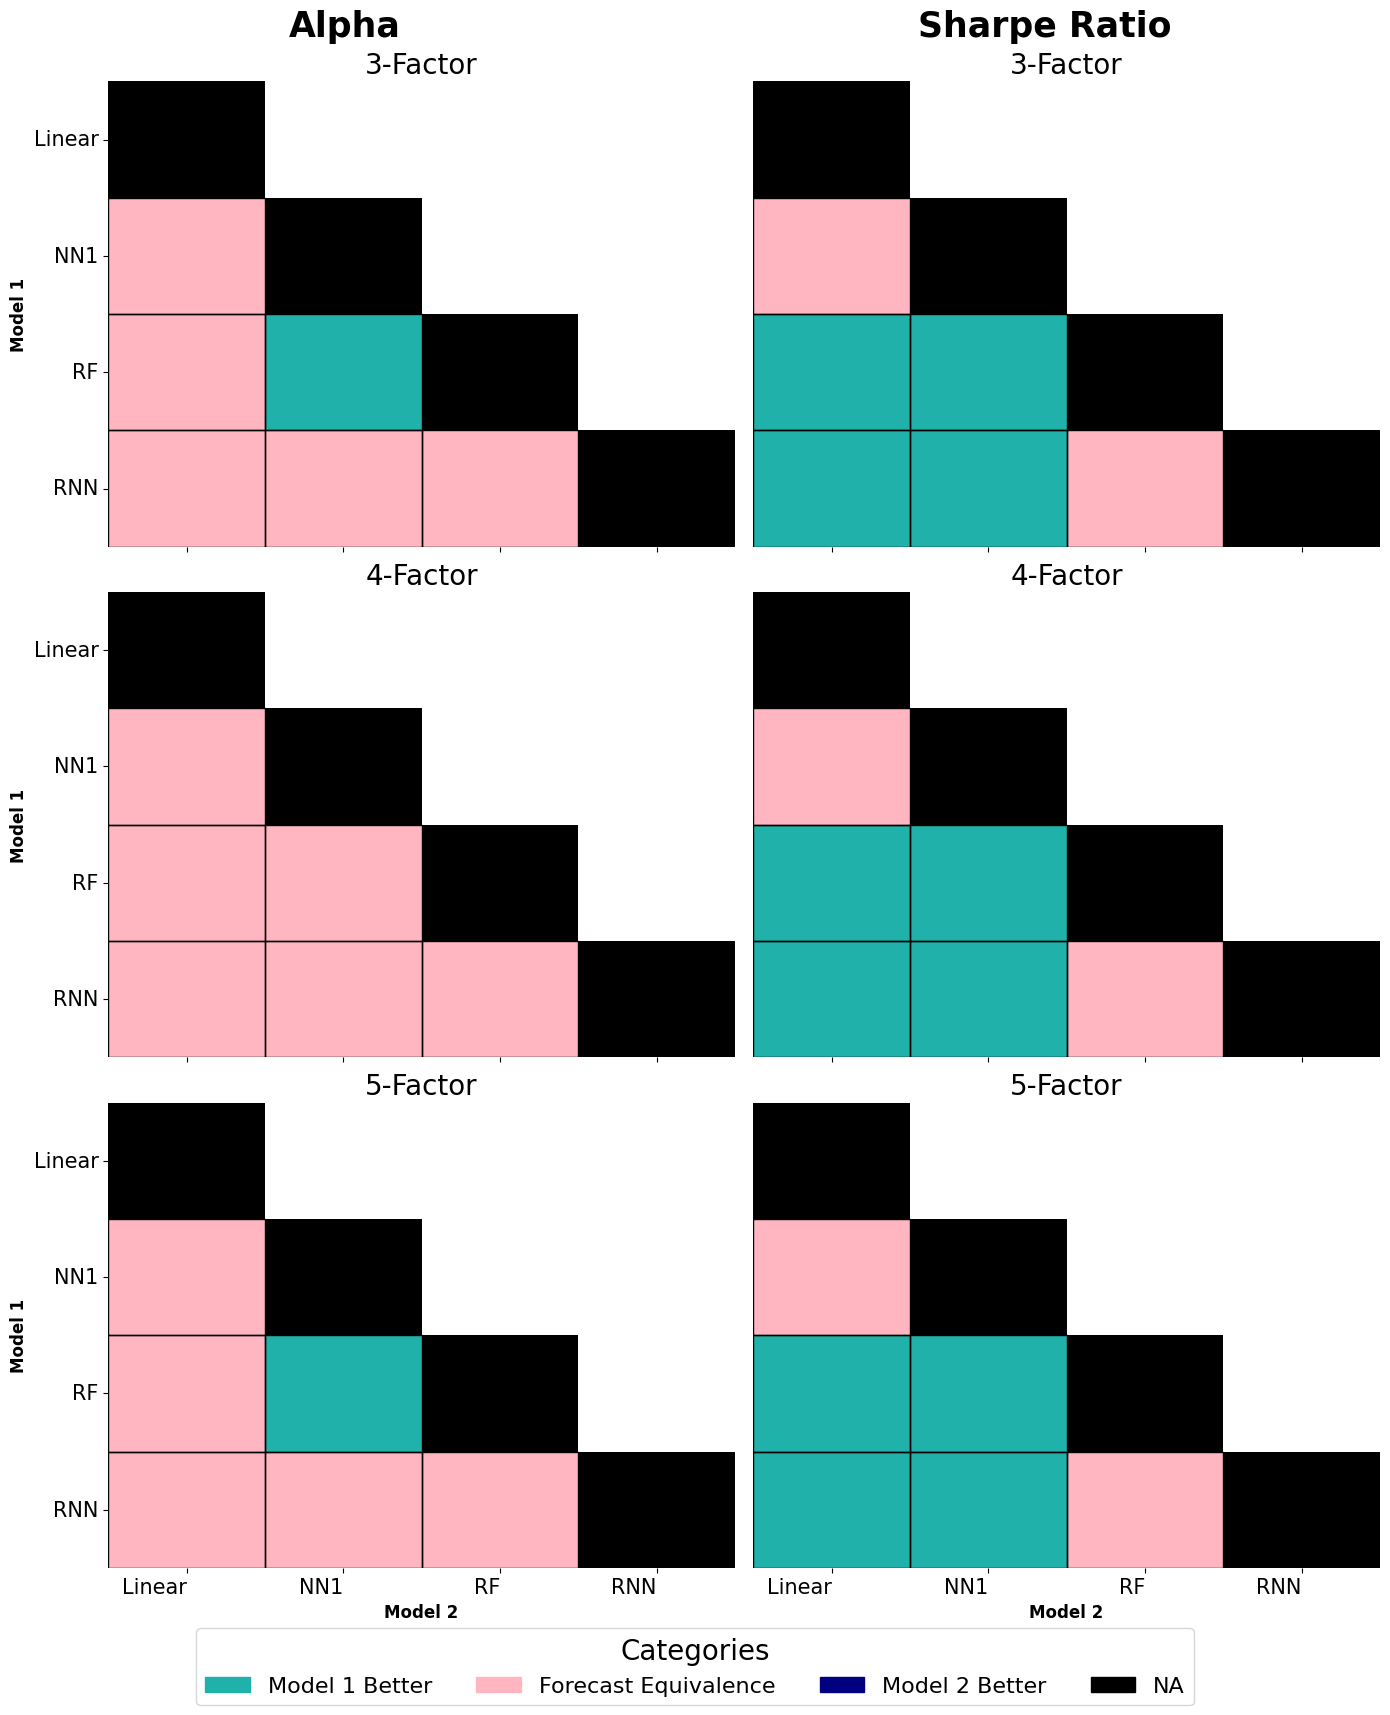

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

def heat_map_plotter(ax, df, title, setyticks=True, xtitle = False, ytitle = False):
    mapping = {"row": -1, "same": 0, "equivalent": 1, "col": 2}

    # Convert categorical values to numerical for visualization
    dm_numeric = df.replace(mapping)

    # Define renaming mapping
    rename_mapping = {
        "linear_3f": "Linear", "linear_4f": "Linear", "linear_5f": "Linear",
        "ffnn_3f": "NN1", "ffnn_4f": "NN1", "ffnn_5f": "NN1",
        "rf_3f": "RF", "rf_4f": "RF", "rf_5f": "RF",
        "3f_rnn": "RNN", "4f_rnn": "RNN", "5f_rnn": "RNN",
        "rnn_3f": "RNN", "rnn_4f": "RNN", "rnn_5f": "RNN",
    }

    # Rename index and columns
    dm_numeric_renamed = dm_numeric.rename(index=rename_mapping, columns=rename_mapping)

    # Define color mapping
    cmap = ListedColormap(["lightseagreen", "#000000", "lightpink", "navy"])
    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(dm_numeric_renamed, dtype=bool), k=1)

    # Set the upper triangle to NaN
    dm_numeric_masked = dm_numeric_renamed.mask(mask)

    # Draw heatmap
    sns.heatmap(
        dm_numeric_masked, cmap=cmap, norm=norm, mask=mask, cbar=False,
        linewidths=0, linecolor="black", ax=ax
    )

    # Manually add black outlines
    for i in range(dm_numeric_masked.shape[0]):
        for j in range(dm_numeric_masked.shape[1]):
            value = dm_numeric_masked.iloc[i, j]
            if value in [-1, 1]:  
                rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="black", linewidth=1)
                ax.add_patch(rect)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=15)
    # Set titles, labels, and formatting
    if setyticks==True:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=15)
    else:
        ax.set_yticks([])
    ax.set_title(title, fontsize=20)
    if xtitle == True:
        ax.set_xlabel("Model 2", fontsize=12, fontweight="bold")
    if ytitle == True:
        ax.set_ylabel("Model 1", fontsize=12, fontweight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right", fontsize=15)
    
    

# Create 3x2 subplot layout
fig, axs = plt.subplots(3, 2, figsize=(14, 16), sharex = True)

# First column (Alpha)
heat_map_plotter(axs[0, 0], dm_transformed_updated_3f_alpha, "3-Factor", setyticks=True, ytitle=True)
heat_map_plotter(axs[1, 0], dm_transformed_updated_4f_alpha, "4-Factor", setyticks=True, ytitle=True)
heat_map_plotter(axs[2, 0], dm_transformed_updated_5f_alpha, "5-Factor", setyticks=True, xtitle = True, ytitle=True)

# Second column (Sharpe Ratio)
heat_map_plotter(axs[0, 1], dm_transformed_updated_3f_sharpe, "3-Factor", setyticks=False)
heat_map_plotter(axs[1, 1], dm_transformed_updated_4f_sharpe, "4-Factor", setyticks=False)
heat_map_plotter(axs[2, 1], dm_transformed_updated_5f_sharpe, "5-Factor", setyticks=False, xtitle = True)

# Adjust layout
plt.tight_layout()

# Add a single legend outside the plot
legend_patches = [
    mpatches.Patch(color="lightseagreen", label="Model 1 Better"),
    mpatches.Patch(color="lightpink", label="Forecast Equivalence"),
    mpatches.Patch(color="navy", label="Model 2 Better"),
    mpatches.Patch(color="#000000", label="NA")
]
fig.legend(handles=legend_patches, loc="lower center", title="Categories", 
           title_fontsize=20, fontsize=16, frameon=True, ncol=4, bbox_to_anchor=(0.5, -0.05))

fig.text(0.25, 1, "Alpha", fontsize=25, fontweight="bold", ha="center")
fig.text(0.75, 1, "Sharpe Ratio", fontsize=25, fontweight="bold", ha="center")

plt.show()